In [1]:
!pip install keras-cv==0.4.0 -q
!pip install -U tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 35.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

In [4]:
data = pd.read_json('/content/drive/MyDrive/Project/raw_data/data_ready_1.json', orient="index")

In [5]:
from ast import literal_eval
data["image"] = data["image"].map(lambda x:literal_eval(x))

In [6]:
data

,text,image
0,person supervillain high contrast default Happ...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
1,o button (blood type) color Neutral,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
2,megaphone color Neutral,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
3,relieved face flat Happiness,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
4,woman with headscarf color Happiness,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
...,...,...
7559,pinching hand flat default Neutral,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
7560,face with diagonal mouth flat Anger,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
7561,woman walking flat light Happiness,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
7562,cloud flat Neutral,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [7]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras

PREPROCESSING

In [8]:
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

tokenizer = SimpleTokenizer()

def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)

# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data), MAX_PROMPT_LENGTH))

all_captions = list(data["text"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


In [ ]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0/127.5, offset=-1),
    ]
)

text_encoder = TextEncoder(MAX_PROMPT_LENGTH)

def process_image(image_data, tokenized_text):
    #image = tf.io.read_file(image_data)
    image = tf.io.decode_png(image_data, 3)
    #image_data = tf.convert_to_tensor(image_data)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text

def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch

def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )
def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }

def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


492466864/492466864 [==============================] - 1s 0us/step


In [ ]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data["image"]), tokenized_texts, batch_size=16
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (16, 256, 256, 3)
tokens (16, 77)
encoded_text (16, 77, 768)


TRAINING

In [ ]:
class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

In [ ]:
USE_MP = True
if USE_MP:
    keras.mixed_precision.set_global_policy("mixed_float16")

RESOLUTION = 256

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)


lr = 1e-5
beta_1, beta_2 = 0.9, 0.95
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

3439090152/3439090152 [==============================] - 9s 0us/step


In [ ]:
epochs = 30
ckpt_path = '/content/drive/MyDrive/Project/finetuned_stable_diffusion30e.h5'
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
history = diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/30


Instructions for updating:
Use fn_output_signature instead


473/473 [==============================] - 614s 662ms/step - loss: 0.0415
Epoch 2/30
473/473 [==============================] - 326s 679ms/step - loss: 0.0354
Epoch 3/30
473/473 [==============================] - 325s 679ms/step - loss: 0.0344
Epoch 4/30
473/473 [==============================] - 327s 683ms/step - loss: 0.0314
Epoch 5/30
473/473 [==============================] - 324s 675ms/step - loss: 0.0318
Epoch 6/30
473/473 [==============================] - 323s 673ms/step - loss: 0.0303
Epoch 7/30
473/473 [==============================] - 326s 681ms/step - loss: 0.0301
Epoch 8/30
473/473 [==============================] - 325s 677ms/step - loss: 0.0298
Epoch 9/30
473/473 [==============================] - 322s 672ms/step - loss: 0.0297
Epoch 10/30
473/473 [==============================] - 324s 676ms/step - loss: 0.0289
Epoch 11/30
473/473 [==============================] - 324s 675ms/step - loss: 0.0286
Epoch 12/30
473/473 [==============================] - 328s 684ms/step - l

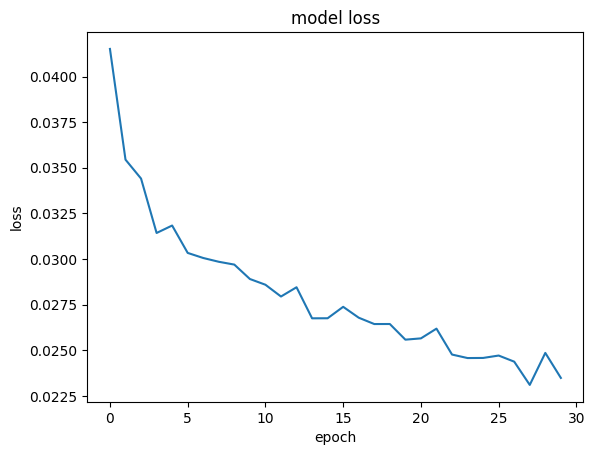

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
img_height = img_width = 360
emotion_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# We just reload the weights of the fine-tuned diffusion model.
emotion_model.diffusion_model.load_weights('/content/drive/MyDrive/Project/finetuned_stable_diffusion2e.h5')
prompts = ["Boy Wearing a Baseball Cap Frustratedly plopped down onto the floor Anger"]
images_to_generate = 1
outputs = {}

for prompt in prompts:
    generated_images = emotion_model.text_to_image(
        prompt, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})

25/25 [==============================] - 3s 119ms/step


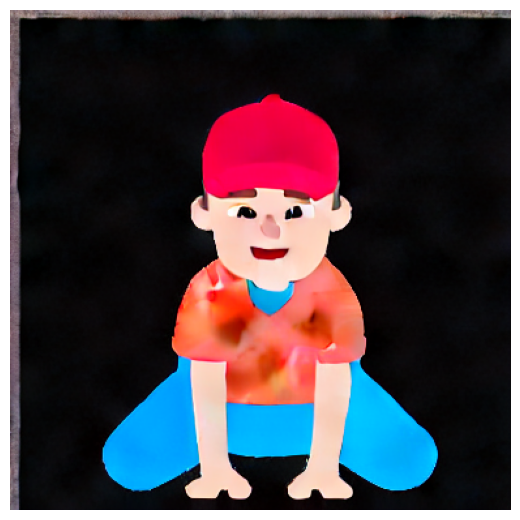

In [ ]:
def plot_images(images, title):
    plt.figure(figsize=(6.5, 6.5))
    for i in range(len(images)):
        #ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        # plt.title(title, fontsize=12)
        plt.axis("off")


for prompt in outputs:
    plot_images(outputs[prompt], prompt)

plt.savefig("/content/drive/MyDrive/Project/output image test/create03.png", dpi=72, bbox_inches='tight', pad_inches = 0)